**Introduction**

In this notebook we want to explore and predict the severity of a roadwork project using the spatiotemporal data available at:

https://www.kaggle.com/datasets/sobhanmoosavi/us-road-construction-and-closures

1% of them are duplicates because they are a combination of mapquest and bing maps

In [ ]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import geopandas as gpd
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
#load the dataset and extract duration, year, months, day, hour, and weekday seperately.

df= pd.read_csv('../input/us-road-construction-and-closures/US_Constructions_Dec21.csv')
#https://www.kaggle.com/code/phip2014/ml-to-predict-accident-severity-pa-mont "copied from here"
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of **minutes** for each construction, round to the nearest integer
td='Duration' 
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))

# it creates a unique name for the location of each project
df['st'] = df["Street"]+df["City"]+df["County"]+df["State"]+df['Zipcode']+df["Number"].astype(str) + df['Side']

# it convrts the 'st' column to numerical classes
#df['loc'] = pd.Categorical(df['st']).codes
n = df[df['State']=="NY"] #new york
nc = df[df['City']=="New York"] #new york city

a lot of the data is missing. look at this table:

In [ ]:
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Percent(%)']
missing['Missing_Percent(%)'] = missing['Missing_Percent(%)'].apply(lambda x: x / df.shape[0] * 100)
missing.loc[missing['Missing_Percent(%)']>0,:]

In [ ]:
nc = df[df['City']=="New York"] #new york city

In [ ]:
pd.set_option('display.max_columns', None)
nc.head()

Data visualization - show states and use a us map.


**what is severity?**

It is defined as the impact of a roadwork on traffic delay. (1 least impact, 4 most impact). They are raw information reported by bing map and mapquest. we dont know how they calculated it.

Let's show the distribution of Severity:

In [ ]:
severity_num=[]
for i in range(4):
    severity_num.append(sum(df['Severity'] == i+1))
severity_num = np.array(severity_num)
percentage = severity_num/sum(severity_num) *100
plt.bar(['1','2','3','4'], percentage, color ='maroon')
plt.xlabel("Severity")
plt.ylabel("% of Constructions")
plt.show()

In [ ]:
#bar plots with filters to better show the boxes.
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.boxplot(x="Severity", y="Distance(mi)", data=df[df['Distance(mi)']<2], palette="Set3", ax=axs[0],showmeans=True)
fig.suptitle('Roadwork Severity vs Distance and Duration', fontsize=16)

sns.boxplot(x="Severity", y="Duration",data=df[df['Duration']<200 ], palette="Set3", ax=axs[1], showmeans=True)
plt.show()

There doesn't seem to be a strict rule that relates Distance or Duration to Severity. But the more severe the roadwork gets, its Duration goes up, and the more severe it gets the more Distance it has except for severity=3 to 4.

In [ ]:
# box plots without the filters to show the outliers better.
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.boxplot(x="Severity", y="Distance(mi)", data=df, palette="Set3", ax=axs[0],showmeans=True)
fig.suptitle('Roadwork Severity vs Distance and Duration', fontsize=16)

sns.boxplot(x="Severity", y="Duration",data=df, palette="Set3", ax=axs[1], showmeans=True)
plt.show()

Most of the projects are of Severity type 2. Since we don't know what this severity really is, let's draw a box plox and 

US map and roadworks

In [ ]:
#https://www.kaggle.com/code/nikitagrec/usa-accidents-plotly-maps-text-classification/notebook
# create df for state accidents

state_count_acc = pd.value_counts(df['State'])

fig = go.Figure(data=go.Choropleth(
    locations=state_count_acc.index,
    z = state_count_acc.values.astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Count Roadworks",
))

fig.update_layout(
    title_text = '2016 - 2021 US Roadworks Dataset by State',
    geo_scope='usa',
)

fig.show()

In [ ]:
state_df = pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'State', 'State':'Cases'})
top_10_states = pd.DataFrame(state_df.head(10))
plt.bar(top_10_states["State"], top_10_states["Cases"], color = 'gray')
plt.title('Top 10 states by # of constructions')
plt.xlabel("State")
plt.ylabel("# of Constructions")
plt.show()

In [ ]:
state_count_acc = pd.value_counts(df[df['Severity'] == 4 ]['State'])

fig = go.Figure(data=go.Choropleth(
    locations=state_count_acc.index,
    z = state_count_acc.values.astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Count Roadworks",
))

fig.update_layout(
    title_text = '2016 - 2021 US Roadworks Dataset by State, Severity = 4',
    geo_scope='usa',
)

fig.show()

In [ ]:
state_df_s4 = pd.DataFrame(df[df["Severity"] == 4]['State'].value_counts()).reset_index().rename(columns={'index':'State', 'State':'Cases'})
top_10_states_s4 = pd.DataFrame(state_df_s4.head(10))
plt.bar(top_10_states_s4["State"], top_10_states_s4["Cases"], color = 'red')
plt.title('Top 10 states by # of constructions, Severity = 4')
plt.xlabel("State")
plt.ylabel("# of Constructions")
plt.show()

In [ ]:
stat_df = pd.DataFrame(df[df['Duration'] >15*24*60]['State'].value_counts()).reset_index().rename(columns={'index':'State', 'State':'Cases'})
st10 = pd.DataFrame(stat_df.head(10))
plt.bar(st10["State"], st10["Cases"], color = 'brown')
plt.title('States vs # of constructions, (Duration > 15 days)')
plt.xlabel("State")
plt.ylabel("# of Constructions")
plt.show()

In [ ]:
city_df = pd.DataFrame(df['City'].value_counts()).reset_index().rename(columns={'index':'City', 'City':'Cases'})
top_10_cities = pd.DataFrame(city_df.head(10))
plt.bar(top_10_cities["City"], top_10_cities["Cases"], color = 'gray')
plt.title('Top 10 cities by # of constructions')
plt.xlabel("City")
plt.ylabel("# of Constructions")
plt.xticks(rotation=90)
plt.show()

In [ ]:
city_df_s4 = pd.DataFrame(df[df["Severity"] == 4]['City'].value_counts()).reset_index().rename(columns={'index':'City', 'City':'Cases'})
top_10_cities_s4 = pd.DataFrame(city_df_s4.head(10))
plt.bar(top_10_cities_s4["City"], top_10_cities_s4["Cases"], color = 'red')
plt.title('Top 10 cities by # of constructions, Severity = 4')
plt.xlabel("City")
plt.ylabel("# of Constructions")
plt.xticks(rotation=90)
plt.show()

In this dataset, Phoenix has the most roadworks. Houston has the most roadworks with severity 4. Total constructions are ... so california has ... % of constructions.

In [ ]:
sum(df['Duration'] >15*24*60)/len(df)

In [ ]:
year_df = pd.DataFrame(df['Year'].value_counts()).reset_index().rename(columns={'index':'Year', 'Year':'Cases'})
top_10_year = pd.DataFrame(year_df.head(10))
plt.bar(top_10_year["Year"], top_10_year["Cases"], color = 'blue')
plt.title('Years vs # of constructions')
plt.xlabel("Year")
plt.ylabel("# of Constructions")
plt.show()

In [ ]:
year_df = pd.DataFrame(df[df['Duration'] >15*24*60]['Year'].value_counts()).reset_index().rename(columns={'index':'Year', 'Year':'Cases'})
plt.bar(year_df["Year"], year_df["Cases"], color = 'red')
plt.title('Years vs # of constructions, (Duration > 15 days)')
plt.xlabel("Year")
plt.ylabel("# of Constructions")
plt.xticks(rotation=90)
plt.show()

In [ ]:
Street_df = pd.DataFrame(df['st'].value_counts()).reset_index().rename(columns={'index':'st', 'st':'Cases'})
top_10_st = pd.DataFrame(Street_df.head(10))
top_10_st

Some roads have had thousands of roadwork. For example "I-5 S Ashland Jackson OR 97520" has had 7975 Roadworks in 6 years.

In [ ]:
#one hot encoding for the starting hour and weekday
one_hot1 = pd.get_dummies(nc['Hour'])
nc = nc.join(one_hot1)
one_hot2 = pd.get_dummies(nc["Weekday"])
nc = nc.join(one_hot2)

In [30]:
wanted = list(nc.columns)
unwanted = ['ID','Start_Time','End_Time','Description','Number','Street','Side','City'
            ,'County','State','Zipcode','Country','Timezone','Airport_Code','Weather_Timestamp'
            ,'Wind_Direction','Weather_Condition','Sunrise_Sunset','Civil_Twilight'
            ,'Nautical_Twilight','Astronomical_Twilight','Month','Day','Hour','Weekday','st','Wind_Chill(F)'
            ,'Wind_Speed(mph)','Turning_Loop','Roundabout'] #dropping wind_speed and wind_chill because of high missing values. (year and severity dropped later)
#drop loc after
for i in unwanted:
    wanted.remove(i)
t = nc[wanted]
t = t.dropna() #dropping rows with missing data (NaN)
t["Severity"] = t["Severity"].apply(lambda x: 0 if x!=4 else 1) # we only care about severity = 4
#apply over and under sampling over here
each_count = 10000 #we want to have 10000 cases of severity 4 and 10000 of other severities.
severe_indices = t[t["Severity"] == 1].index
random.seed(23)
random_indices1 = np.random.choice(severe_indices, each_count , replace=True)
over_sample = t.loc[random_indices1]

nsevere_indices = t[t["Severity"] == 0].index
random_indices2 = np.random.choice(nsevere_indices, each_count , replace=True)
under_sample = t.loc[random_indices2]

frames = [over_sample, under_sample]
t = pd.concat(frames)

X_train = t[t['Year'] !=2021].loc[:, (t.columns != 'Severity')&(t.columns != 'Year')]
y_train = t[t['Year'] !=2021]['Severity']
X_test  = t[t['Year'] ==2021].loc[:, (t.columns != 'Severity')&(t.columns != 'Year')]
y_test  = t[t['Year'] ==2021]['Severity']

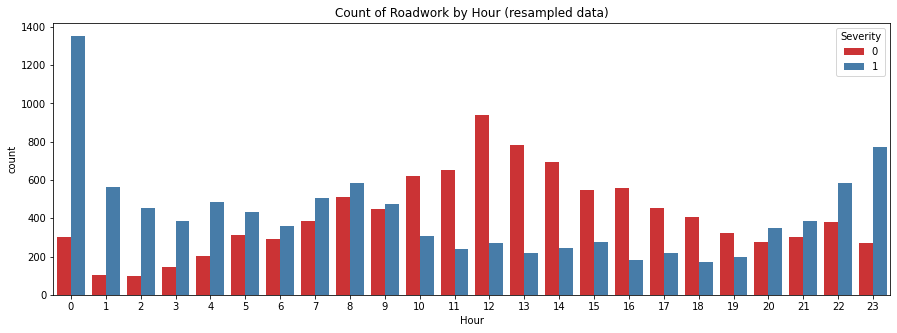

In [32]:
plt.figure(figsize=(15,5))
t2 = t.join(nc["Hour"])
t2 = t2.join(nc["Weekday"])
sns.countplot(x='Hour', hue='Severity', data=t2 ,palette="Set1")
plt.title('Count of Roadwork by Hour (resampled data)')
plt.show()

AB testing to see if the duration of the roadworks starting at midnight is significantly bigger than other project's durations:


In [33]:
x1 = t2[t2['Hour'] == 0]["Duration"]
x2 = t2[t2['Hour'] != 0]["Duration"]
x1_mean = np.mean(x1)
x2_mean = np.mean(x2)
n1 = len(x1)
n2 = len(x2)
sx1 = np.std(x1)
sx2 = np.std(x2)
sx1x2 = (sx1**2/n1+sx2**2/n2)**0.5

print(x1_mean)
print(x2_mean)
print(x1_mean - x2_mean - 1.96*sx1x2)
print(x1_mean - x2_mean + 1.96*sx1x2)

17885.35929951691
17532.68147623201
-4749.203875898069
5454.559522467867


their duration is bigger but it is not significant.

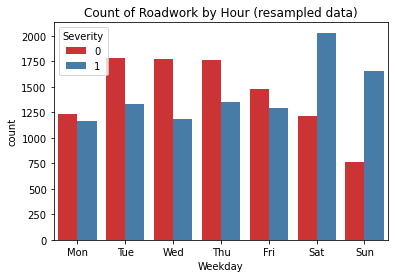

In [34]:
order = ["Mon",'Tue',"Wed","Thu","Fri","Sat","Sun"]
sns.countplot(x='Weekday', hue='Severity', data=t2 ,palette="Set1", order = order)
plt.title('Count of Roadwork by Hour (resampled data)')
plt.show()

In [35]:
x1 = t2[(t2['Weekday'] != "Sat") & (t2['Weekday'] != "Sun")]["Duration"]
x2 = t2[(t2['Weekday'] == "Sat") | (t2['Weekday'] == "Sun")]["Duration"]
x1_mean = np.mean(x1)
x2_mean = np.mean(x2)
n1 = len(x1)
n2 = len(x2)
sx1 = np.std(x1)
sx2 = np.std(x2)
sx1x2 = (sx1**2/n1+sx2**2/n2)**0.5

print(x1_mean)
print(x2_mean)
print(x1_mean - x2_mean - 1.96*sx1x2)
print(x1_mean - x2_mean + 1.96*sx1x2)

19425.81296619031
12833.66525198939
4676.414308150504
8507.881120251337


roadworks happening during weekdays significantly have more duration than those in weekends.

In [36]:
print( str(round(sum(y_train == 1)/len(y_train)*100)) +'% of our training dataset of NYC is of severity 4 type of roadwork.'  )
print( str(round(sum(y_test == 1)/len(y_test)*100)) +'% of our test dataset of NYC is of severity 4 type of roadwork.'  )
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

61% of our training dataset of NYC is of severity 4 type of roadwork.
42% of our test dataset of NYC is of severity 4 type of roadwork.
(8528, 53)
(8528,)
(11472, 53)
(11472,)


**Logistic Regression Model:**

[[1726 4971]
 [ 657 4118]]
accuracy score is: 50.9%
AUC of ROC = 0.593


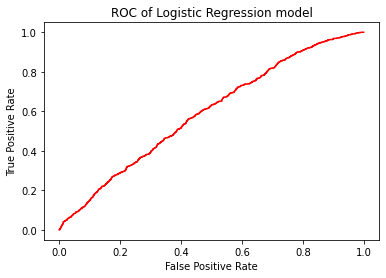

In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logistic = logreg.predict(X_test)
accuracy_logistic = round(accuracy_score(y_test,y_pred_logistic) , 3)*100
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

print(metrics.confusion_matrix(y_test, y_pred_logistic))
print("accuracy score is: " + str(accuracy_logistic) +"%")
print('AUC of ROC = '+str(round(roc_auc_score(y_test, y_pred_proba),3)))

#plot ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr,tpr, color = 'red')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC of Logistic Regression model")
plt.show()

[[5288 1409]
 [1511 3264]]
accuracy score is: 74.5%
AUC of ROC = 0.838


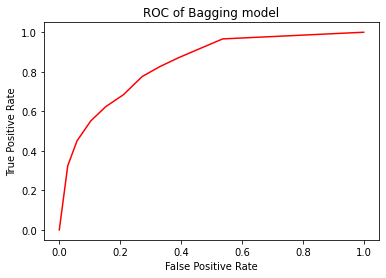

In [44]:
bagging_model = BaggingClassifier().fit(X_train, y_train)
y_pred_bag = bagging_model.predict(X_test)
accuracy_bag = round(accuracy_score(y_test,y_pred_bag) , 3)*100
y_pred_proba = bagging_model.predict_proba(X_test)[:, 1]

print(metrics.confusion_matrix(y_test, y_pred_bag))
print("accuracy score is: " + str(accuracy_bag) +"%")
print('AUC of ROC = '+str(round(roc_auc_score(y_test, y_pred_proba),3)))

#plot ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr,tpr, color = 'red')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC of Bagging model")
plt.show()

**Random Forest Model:**

[[5706  991]
 [1006 3769]]
accuracy score is: 82.6%
AUC of ROC = 0.908


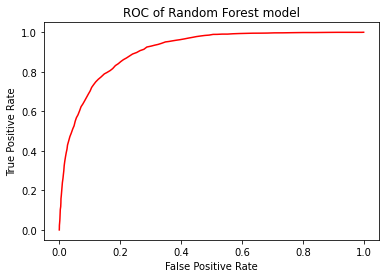

In [47]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)
accuracy_forest = round(accuracy_score(y_test,y_pred_forest) , 3)*100
y_pred_proba = forest.predict_proba(X_test)[:, 1]

print(metrics.confusion_matrix(y_test, y_pred_forest))
print("accuracy score is: " + str(accuracy_forest) +"%")
print('AUC of ROC = '+str(round(roc_auc_score(y_test, y_pred_proba),3)))

#plot ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr,tpr, color = 'red')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC of Random Forest model")
plt.show()

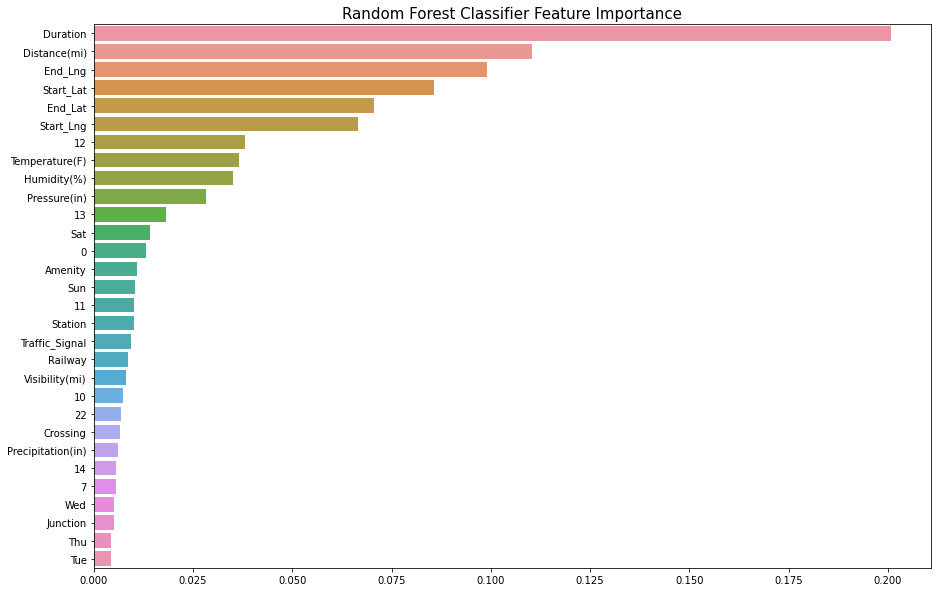

In [52]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=['importance'], index=X_train.columns)

importances.iloc[:,0] = forest.feature_importances_

importances.sort_values(by='importance', inplace=True, ascending=False)
importances30 = importances.head(30)

plt.figure(figsize=(15, 10))
sns.barplot(x='importance', y=importances30.index, data=importances30)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Random Forest Classifier Feature Importance', size=15)

plt.show()

Duration, Distance(mi), End_Lng, Start_Lat, End_Lat, Start_Lng are the most important predictors, and it was almost expected.

0.7456415620641562
[[4601 2096]
 [ 822 3953]]
accuracy score is: 74.6%
AUC of ROC = 0.863


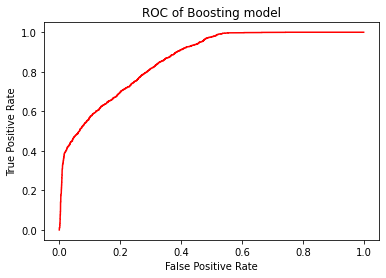

In [50]:
boost = GradientBoostingClassifier().fit(X_train, y_train)
y_pred_boost = boost.predict(X_test)
print(accuracy_score(y_test, y_pred_boost))

y_pred_boost = boost.predict(X_test)
accuracy_boost = round(accuracy_score(y_test,y_pred_boost) , 3)*100
y_pred_proba = boost.predict_proba(X_test)[:, 1]

print(metrics.confusion_matrix(y_test, y_pred_boost))
print("accuracy score is: " + str(accuracy_boost) +"%")
print('AUC of ROC = '+str(round(roc_auc_score(y_test, y_pred_proba),3)))

#plot ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr,tpr, color = 'red')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC of Boosting model")
plt.show()

In [53]:
for i in range(10):
    print(str(i+1) +')  '+ n[(n['City']=='New York') & (n['Severity'] == 4) ]['Description'].iloc[i] + "  "+ str(n[(n['City']=='New York') & (n['Severity'] == 4) ]['Duration'].iloc[i]))
print()
for i in range(10):
    print(str(i+1) +')  '+ n[(n['City']=='New York') & (n['Severity'] == 1) ]['Description'].iloc[i] + "  "+ str(n[(n['City']=='New York') & (n['Severity'] == 1) ]['Duration'].iloc[i]))

1)  COVID-19 - Outdoor dining. Closed road from 6th Ave/Avenue of the Americas (Spring St) to W Broadway (Spring St) due to roadwork.  11278.0
2)  Closed road from 9th Ave to 10th Ave due to roadwork.  5558.0
3)  Closed at 79th St - Closed. Construction work.  360.0
4)  NYSDOT - Region 11: construction on E 90TH ST eastbound between MADISON AVE (New York) and PARK AVE (New York) for major gas installation Sunday April 4th 2021 09:00 AM thru 06:00 PM All lanes closed  899.0
5)  Closed road from NY-495/Lincoln Tunnel (Dyer Ave) to 41st St (Dyer Ave) due to roadwork.  11248.0
6)  Closed between Greenwich St and Trinity Pl - Closed due to roadwork.  3900.0
7)  Closed road from W 16th St (9th Ave) to W 14th St (9th Ave) due to roadwork.  10799.0
8)  Closed between 9th Ave and Dyer Ave - Closed due to roadwork.  360.0
9)  COVID-19 - Outdoor dining. Closed road from W 34th St (Broadway) to E 23rd St (Broadway) due to roadwork.  11424.0
10)  Closed at Washington Sq E - Closed due to roadwork. 